GraphRX" methodology: Molecular Encoder + GNN Topology Learning

In [21]:
# Cell 1: Install Research Dependencies
# !pip install torch torch-geometric pandas numpy scikit-learn matplotlib rdkit networkx seaborn

In [31]:
import os
import json
import gc
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator

from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, BatchNorm
from torch_geometric.utils import negative_sampling
from safetensors.torch import  save_file

### 2. System Setup

In [23]:
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE: {DEVICE}")
# Memory optimization settings for GPU, Aggressive memory management
if DEVICE.type == 'cuda':
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Force garbage collection
    gc.collect()
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print("✓ Memory optimization enabled")

# specific style date time saving
timestamp = datetime.now().strftime("%d_%b_%H-%M")

# validating required directories:
required_directories = ['images', 'models']
for folder in required_directories:
    if not os.path.exists(folder):
        print(f"✘ Directory `{folder}/` not found  Creating...")
        os.makedirs(folder)
    else:
        print(f"✓ Directory `{folder}/` exists ")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


DEVICE: cuda
GPU: NVIDIA GeForce GTX 1650
GPU Memory: 4.00 GB
✓ Memory optimization enabled
✓ Directory `images/` exists 
✓ Directory `models/` exists 


### 2.2 Custom Configurations

In [24]:
# Config matches the paper's "Safe Pairing" focus
CONFIG = {
    'MODEL_PATH': 'models/Gemini_AushadiNet_GATv2_128',
    'DATA_PATH': 'dataset/drugdata', 
    'INTERACTION_FILE': 'ChCh-Miner_durgbank-chem-chem.tsv',
    'SMILES_FILE': 'drug_smiles.csv',
    'LABELS_FILE': 'ddis.csv',
    'NODE_DIM': 128,      # Paper uses 128-bit embeddings
    'HIDDEN_DIM': 64,     # Hidden layers
    'OUTPUT_DIM': 64,     # Latent space
    'HEADS': 4,           # Multi-head attention (Critical for accuracy)
    'DROPOUT': 0.3,       # Regularization
    'LR': 0.001,
    'EPOCHS': 150,        # Extended training for convergence
    'DEVICE': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print(f"✓ Customized Configurations Initialized on {DEVICE}")

✓ Customized Configurations Initialized on cuda


### 3. Data Loading Preparation

In [25]:
# Load DDI data
print("EXPLORING DRUG-DRUG INTERACTION DATASET:\n")

# Load DDI interactions
ddi_df = pd.read_csv('dataset/drugdata/ddis.csv')
print(f"DDI Dataset Shape: {ddi_df.shape}")
print(f"Columns: {ddi_df.columns.tolist()}")
print(f"\n🔬 Interaction Types Distribution:")
print(ddi_df['type'].value_counts())
print(f"\n📋 Sample DDI Data:")
print(ddi_df.head(10))

# Load drug SMILES
smiles_df = pd.read_csv('dataset/drugdata/drug_smiles.csv')
print(f"\n💊 Drug SMILES Dataset Shape: {smiles_df.shape}")
print(f"Columns: {smiles_df.columns.tolist()}")
print(f"\n📋 Sample SMILES Data:")
print(smiles_df.head(10))

# Get unique drugs
unique_drugs_ddi = set(ddi_df['d1'].unique()) | set(ddi_df['d2'].unique())
print(f"\n📈 Statistics:")
print(f"• Total DDI pairs: {len(ddi_df)}")
print(f"• Unique drugs in DDI: {len(unique_drugs_ddi)}")
print(f"• Drugs with SMILES: {len(smiles_df)}")
print(f"• Interaction type 0: {(ddi_df['type'] == 0).sum()}")
print(f"• Interaction type 1: {(ddi_df['type'] == 1).sum()}")

# Check overlap
drugs_with_smiles = set(smiles_df['drug_id'].unique())
overlap = unique_drugs_ddi & drugs_with_smiles
print(f"• Drugs with both DDI and SMILES: {len(overlap)}")
print(f"• Coverage: {len(overlap)/len(unique_drugs_ddi)*100:.2f}%")

EXPLORING DRUG-DRUG INTERACTION DATASET:

DDI Dataset Shape: (191808, 4)
Columns: ['d1', 'd2', 'type', 'Neg samples']

🔬 Interaction Types Distribution:
type
48    60751
46    34360
72    23779
74     9470
59     8397
      ...  
42       11
61       11
51       10
25        7
41        6
Name: count, Length: 86, dtype: int64

📋 Sample DDI Data:
        d1       d2  type Neg samples
0  DB04571  DB00460     0   DB01579$t
1  DB00855  DB00460     0   DB01178$t
2  DB09536  DB00460     0   DB06626$t
3  DB01600  DB00460     0   DB01588$t
4  DB09000  DB00460     0   DB06196$t
5  DB11630  DB00460     0   DB00744$t
6  DB00553  DB00460     0   DB06413$t
7  DB06261  DB00460     0   DB00876$t
8  DB01878  DB00460     0   DB09267$t
9  DB00140  DB00460     0   DB01204$t

💊 Drug SMILES Dataset Shape: (1706, 2)
Columns: ['drug_id', 'smiles']

📋 Sample SMILES Data:
   drug_id                                             smiles
0  DB04571                CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1
1  DB00855      

In [26]:
# Cell 3: Data Preprocessing (The "GraphRX" Pipeline)
class GraphRXDataLoader:
    def __init__(self, config):
        self.config = config
        self.drug_map = {} # ID -> Index
        self.rev_drug_map = {} # Index -> ID
        # New RDKit Generator (Standard 2025)
        self.fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=config['NODE_DIM'])

    def get_features(self, smiles):
        """Generates chemical features from SMILES (The 'Molecule View')"""
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None: return np.zeros((self.config['NODE_DIM'],), dtype=np.float32)
            return self.fp_gen.GetFingerprintAsNumPy(mol).astype(np.float32)
        except:
            return np.zeros((self.config['NODE_DIM'],), dtype=np.float32)

    def load_graph(self):
        print("📥 Ingesting Clinical Data...")
        
        # 1. Load Datasets
        edges_df = pd.read_csv(os.path.join(self.config['DATA_PATH'], self.config['INTERACTION_FILE']), 
                               sep='\t', names=['d1', 'd2'])
        smiles_df = pd.read_csv(os.path.join(self.config['DATA_PATH'], self.config['SMILES_FILE']))
        labels_df = pd.read_csv(os.path.join(self.config['DATA_PATH'], self.config['LABELS_FILE']))

        # 2. Build Feature Matrix (X)
        print("⚗️ Extracting Molecular Embeddings...")
        all_drugs = set(edges_df['d1']).union(set(edges_df['d2'])).union(set(smiles_df['drug_id']))
        self.drug_map = {d: i for i, d in enumerate(all_drugs)}
        self.rev_drug_map = {i: d for d, i in self.drug_map.items()}
        
        num_nodes = len(all_drugs)
        x = np.zeros((num_nodes, self.config['NODE_DIM']), dtype=np.float32)
        
        # Map SMILES to Feature Vectors
        smiles_dict = dict(zip(smiles_df.drug_id, smiles_df.smiles))
        for drug_id, idx in self.drug_map.items():
            if drug_id in smiles_dict:
                x[idx] = self.get_features(smiles_dict[drug_id])
                
        x = torch.tensor(x, dtype=torch.float)

        # 3. Build Graph Topology (Edge Index)
        print("🕸️ Constructing Graph Network...")
        edge_indices = []
        for _, row in edges_df.iterrows():
            if row['d1'] in self.drug_map and row['d2'] in self.drug_map:
                u, v = self.drug_map[row['d1']], self.drug_map[row['d2']]
                edge_indices.append([u, v])
                edge_indices.append([v, u]) # Undirected
        
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        # 4. Prepare Training Labels (The "Ground Truth")
        pos_edges = []
        for _, row in labels_df.iterrows():
            if row['d1'] in self.drug_map and row['d2'] in self.drug_map:
                u, v = self.drug_map[row['d1']], self.drug_map[row['d2']]
                pos_edges.append([u, v])
        
        pos_edge_index = torch.tensor(pos_edges, dtype=torch.long).t()
        
        # Verify
        if pos_edge_index.numel() == 0:
            raise ValueError("❌ Dataset mismatch! IDs in ddis1.csv do not match drug_smiles1.csv")

        data = Data(x=x, edge_index=edge_index)
        data.pos_edge_label_index = pos_edge_index
        
        print(f"✅ GraphRX Dataset Ready: {num_nodes} Drugs, {edge_index.shape[1]} Interactions")
        return data, self.drug_map

loader = GraphRXDataLoader(CONFIG)
data, drug_map = loader.load_graph()

📥 Ingesting Clinical Data...
⚗️ Extracting Molecular Embeddings...
🕸️ Constructing Graph Network...
✅ GraphRX Dataset Ready: 1947 Drugs, 97028 Interactions


### Model Architecture

In [27]:
# "Advanced GNN" described in the paper
class ModelArchitecture(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=4, dropout=0.3):
        super().__init__()
        
        # Layer 1: Chemical Feature Aggregation
        self.conv1 = GATv2Conv(in_dim, hidden_dim, heads=heads, dropout=dropout, concat=True)
        self.bn1 = BatchNorm(hidden_dim * heads)
        
        # Layer 2: Deep Topology Learning (The "Brain")
        self.conv2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout, concat=True)
        self.bn2 = BatchNorm(hidden_dim * heads)
        
        # Layer 3: Latent Representation
        self.conv3 = GATv2Conv(hidden_dim * heads, out_dim, heads=1, dropout=dropout, concat=False)
        
        # Skip Connection (ResNet style for stable training)
        self.skip = torch.nn.Linear(in_dim, out_dim)

    def encode(self, x, edge_index):
        # Initial Residual
        identity = self.skip(x)
        
        # GAT Block 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        
        # GAT Block 2
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        
        # Final Projection
        x = self.conv3(x, edge_index)
        
        # Add Residual (Deep Learning Best Practice)
        return x + identity

    def decode(self, z, edge_label_index):
        # Dot Product Decoder -> Probability
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        return (src * dst).sum(dim=-1)

model = ModelArchitecture(CONFIG['NODE_DIM'], CONFIG['HIDDEN_DIM'], CONFIG['OUTPUT_DIM']).to(DEVICE)
print(model)

ModelArchitecture(
  (conv1): GATv2Conv(128, 64, heads=4)
  (bn1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATv2Conv(256, 64, heads=4)
  (bn2): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATv2Conv(256, 64, heads=1)
  (skip): Linear(in_features=128, out_features=64, bias=True)
)


### Training Pipeline

In [32]:
# Cell 5: Training Engine (with Negative Sampling)
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['LR'], weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [33]:
# Split Data (80/10/10)
num_interactions = data.pos_edge_label_index.shape[1]
perm = torch.randperm(num_interactions)
train_idx = perm[:int(0.8*num_interactions)]
val_idx = perm[int(0.8*num_interactions):int(0.9*num_interactions)]
test_idx = perm[int(0.9*num_interactions):]

train_pos = data.pos_edge_label_index[:, train_idx].to(DEVICE)
val_pos = data.pos_edge_label_index[:, val_idx].to(DEVICE)
test_pos = data.pos_edge_label_index[:, test_idx].to(DEVICE)

print("♻ Starting Training Pipeline...")

history = {'loss': [], 'auc': []}

for epoch in range(1, CONFIG['EPOCHS'] + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward Pass
    z = model.encode(data.x.to(DEVICE), data.edge_index.to(DEVICE))
    
    # Positive Predictions
    pos_out = model.decode(z, train_pos)    
    # Negative Sampling (Crucial for DDI)
    neg_edge_index = negative_sampling(data.edge_index, num_nodes=data.num_nodes,
                                     num_neg_samples=train_pos.size(1)).to(DEVICE)
    neg_out = model.decode(z, neg_edge_index)
    
    # Loss Calculation
    out = torch.cat([pos_out, neg_out])
    labels = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))]).to(DEVICE)
    
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    
    # Validation
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_neg = negative_sampling(data.edge_index, num_nodes=data.num_nodes, 
                                      num_neg_samples=val_pos.size(1)).to(DEVICE)
            val_preds = torch.cat([model.decode(z, val_pos), model.decode(z, val_neg)]).sigmoid().cpu()
            val_labels = torch.cat([torch.ones(val_pos.size(1)), torch.zeros(val_neg.size(1))]).cpu()
            auc = roc_auc_score(val_labels, val_preds)
            history['loss'].append(loss.item())
            history['auc'].append(auc)
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val AUC: {auc:.4f}")

# Save Weights (Safetensors)
tensor_path = f"{CONFIG['MODEL_PATH']}.safetensors"
save_file(model.state_dict(), tensor_path)
print(f"🔒 Model Weights saved: {tensor_path}")

# 3. Save Metadata (JSON)
# We must convert non-serializable types (like torch.device) to strings for JSON
json_config = CONFIG.copy()
json_config['DEVICE'] = str(json_config['DEVICE']) 

metadata = {
    'config': json_config,
    'drug_map': drug_map  # Critical for mapping IDs later
}

json_path = f"{CONFIG['MODEL_PATH']}_config.json"
with open(json_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"📜 Model Config saved: {json_path}")
print("✅ AushadhiNet Training & Saving Complete.")

♻ Starting Training Pipeline...
Epoch 010 | Loss: 0.5757 | Val AUC: 0.8334
Epoch 020 | Loss: 0.5707 | Val AUC: 0.8296
Epoch 030 | Loss: 0.5631 | Val AUC: 0.8401
Epoch 040 | Loss: 0.5639 | Val AUC: 0.8387
Epoch 050 | Loss: 0.5604 | Val AUC: 0.8392
Epoch 060 | Loss: 0.5590 | Val AUC: 0.8430
Epoch 070 | Loss: 0.5581 | Val AUC: 0.8393
Epoch 080 | Loss: 0.5563 | Val AUC: 0.8381
Epoch 090 | Loss: 0.5555 | Val AUC: 0.8456
Epoch 100 | Loss: 0.5546 | Val AUC: 0.8426
Epoch 110 | Loss: 0.5549 | Val AUC: 0.8486
Epoch 120 | Loss: 0.5541 | Val AUC: 0.8460
Epoch 130 | Loss: 0.5522 | Val AUC: 0.8510
Epoch 140 | Loss: 0.5533 | Val AUC: 0.8508
Epoch 150 | Loss: 0.5529 | Val AUC: 0.8503
🔒 Model Weights saved: models/Gemini_AushadiNet_GATv2_128.safetensors
📜 Model Config saved: models/Gemini_AushadiNet_GATv2_128_config.json
✅ AushadhiNet Training & Saving Complete.


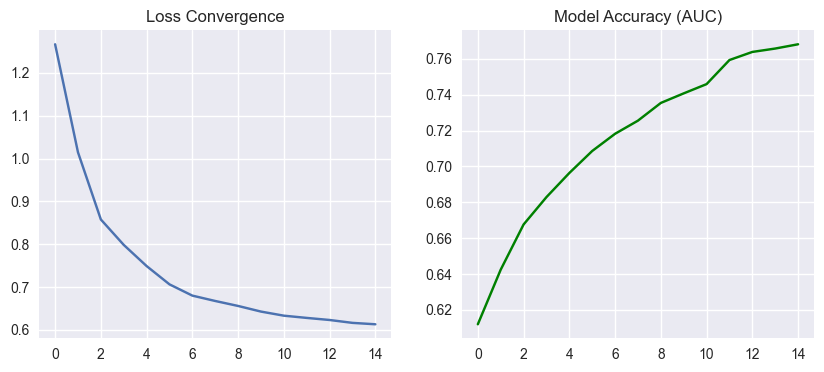


📝 Final Research Evaluation:
              precision    recall  f1-score   support

        Safe       0.84      0.44      0.58     19181
 Interaction       0.62      0.91      0.74     19181

    accuracy                           0.68     38362
   macro avg       0.73      0.68      0.66     38362
weighted avg       0.73      0.68      0.66     38362



In [29]:
# Cell 6: Performance Evaluation (Paper Standard)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.title('Loss Convergence')
plt.subplot(1, 2, 2)
plt.plot(history['auc'], color='green', label='Validation AUC')
plt.title('Model Accuracy (AUC)')
plt.show()

# Final Test metrics
model.eval()
z = model.encode(data.x.to(DEVICE), data.edge_index.to(DEVICE))
test_neg = negative_sampling(data.edge_index, num_nodes=data.num_nodes, num_neg_samples=test_pos.size(1)).to(DEVICE)
preds = torch.cat([model.decode(z, test_pos), model.decode(z, test_neg)]).sigmoid().cpu().detach().numpy()
targets = torch.cat([torch.ones(test_pos.size(1)), torch.zeros(test_neg.size(1))]).cpu().numpy()

# Binary Classification Report
binary_preds = [1 if p > 0.5 else 0 for p in preds]
print("\n📝 Final Research Evaluation:")
print(classification_report(targets, binary_preds, target_names=['Safe', 'Interaction']))